In [1]:
# Classificação com Naive Bayes
# Filtrando mensagens de Spam via SMS
# http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/

# Obs: Caso tenha problemas com a acentuação, consulte este link:
# https://support.rstudio.com/hc/en-us/articles/200532197-Character-Encoding

# Definindo o diretório de trabalho
getwd()
#setwd("~/Dropbox/DSA/MachineLearning/Cap07/R")

[1] "C:/Users/cassi/OneDrive/Programação/DSA/MachineLearning2.0/Cap07-R"

In [2]:
# Pacotes
install.packages("slam")
install.packages("tm")
install.packages("SnowballC")
install.packages("wordcloud")
install.packages("gmodels")
library(tm)
library(SnowballC)
library(wordcloud)
library(e1071)
library(gmodels)

package 'slam' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cassi\AppData\Local\Temp\RtmpwdfqmV\downloaded_packages


also installing the dependency 'NLP'



package 'NLP' successfully unpacked and MD5 sums checked
package 'tm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cassi\AppData\Local\Temp\RtmpwdfqmV\downloaded_packages
package 'SnowballC' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cassi\AppData\Local\Temp\RtmpwdfqmV\downloaded_packages
package 'wordcloud' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cassi\AppData\Local\Temp\RtmpwdfqmV\downloaded_packages


also installing the dependency 'gdata'



package 'gdata' successfully unpacked and MD5 sums checked
package 'gmodels' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cassi\AppData\Local\Temp\RtmpwdfqmV\downloaded_packages


Warning message:
"package 'tm' was built under R version 3.6.3"Loading required package: NLP
Warning message:
"package 'NLP' was built under R version 3.6.3"Warning message:
"package 'SnowballC' was built under R version 3.6.3"Warning message:
"package 'wordcloud' was built under R version 3.6.3"Loading required package: RColorBrewer
Warning message:
"package 'e1071' was built under R version 3.6.3"Warning message:
"package 'gmodels' was built under R version 3.6.3"

In [4]:
# Carregando os dados
dados <- read.csv("sms_spam.csv", stringsAsFactors = FALSE)

# Examinando a estrutura dos dados
str(dados)

'data.frame':	5559 obs. of  2 variables:
 $ type: chr  "ham" "ham" "ham" "spam" ...
 $ text: chr  "Hope you are having a good week. Just checking in" "K..give back my thanks." "Am also doing in cbe only. But have to pay." "complimentary 4 STAR Ibiza Holiday or Â£10,000 cash needs your URGENT collection. 09066364349 NOW from Landline"| __truncated__ ...


In [5]:
# Convertendo para fator
dados$type <- factor(dados$type)

In [7]:
# Examinando a estrutura dos dados
str(dados$type)

 Factor w/ 2 levels "ham","spam": 1 1 1 2 2 1 1 1 2 1 ...


In [8]:
table(dados$type)


 ham spam 
4812  747 

In [9]:
# Construindo um Corpus
dados_corpus <- VCorpus(VectorSource(dados$text))

In [11]:
# Examinando a estrutura dos dados
print(dados_corpus)


<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 5559


In [12]:
inspect(dados_corpus[1:2])

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 2

[[1]]
<<PlainTextDocument>>
Metadata:  7
Content:  chars: 49

[[2]]
<<PlainTextDocument>>
Metadata:  7
Content:  chars: 23



In [14]:
# Ajustando a estrutura
as.character(dados_corpus[[1]])

[1] "Hope you are having a good week. Just checking in"

In [15]:
lapply(dados_corpus[1:2], as.character)

$`1`
[1] "Hope you are having a good week. Just checking in"

$`2`
[1] "K..give back my thanks."

In [16]:
# Limpeza do Corpus com tm_map()
?tm_map
dados_corpus_clean <- tm_map(dados_corpus, content_transformer(tolower))

In [17]:
# Diferenças entre o Corpus inicial e o Corpus após a limpeza
as.character(dados_corpus[[1]])
as.character(dados_corpus_clean[[1]])

[1] "Hope you are having a good week. Just checking in"

[1] "hope you are having a good week. just checking in"

In [18]:
# Outras etapas de limpeza
dados_corpus_clean <- tm_map(dados_corpus_clean, removeNumbers) # remove números
dados_corpus_clean <- tm_map(dados_corpus_clean, removeWords, stopwords()) # remove stop words
dados_corpus_clean <- tm_map(dados_corpus_clean, removePunctuation) # remove pontuação

In [19]:
# Criando uma função para substituir ao invés de remover pontuação
removePunctuation("hello...world")
replacePunctuation <- function(x) { gsub("[[:punct:]]+", " ", x) }
replacePunctuation("hello...world")

[1] "helloworld"

[1] "hello world"

In [20]:
# Word stemming
?wordStem
wordStem(c("learn", "learned", "learning", "learns"))

[1] "learn" "learn" "learn" "learn"

In [21]:
# Aplicando Stem
dados_corpus_clean <- tm_map(dados_corpus_clean, stemDocument)

In [22]:
# Eliminando espaço em branco
dados_corpus_clean <- tm_map(dados_corpus_clean, stripWhitespace) 

In [24]:
# Examinando a versão final do Corpus
lapply(dados_corpus[1:3], as.character)

$`1`
[1] "Hope you are having a good week. Just checking in"

$`2`
[1] "K..give back my thanks."

$`3`
[1] "Am also doing in cbe only. But have to pay."

In [25]:
lapply(dados_corpus_clean[1:3], as.character)

$`1`
[1] "hope good week just check"

$`2`
[1] "kgive back thank"

$`3`
[1] "also cbe pay"

In [26]:
# Criando uma matriz esparsa document-term
?DocumentTermMatrix
dados_dtm <- DocumentTermMatrix(dados_corpus_clean)

In [27]:
# Solução alternartiva 2 - cira uma matriz esparsa  document-term direto a partir do Corpus
dados_dtm2 <- DocumentTermMatrix(dados_corpus, control = list(tolower = TRUE, 
                                                              removeNumbers = TRUE, 
                                                              stopwords = TRUE, 
                                                              removePunctuation = TRUE,
                                                              stemming = TRUE))

In [28]:
# Solução alternativa 3 - usando stop words customizadas a partir da função
dados_dtm3 <- DocumentTermMatrix(dados_corpus, control = list(tolower = TRUE,
                                                              removeNumbers = TRUE,
                                                              stopwords = function(x) { removeWords(x, stopwords()) },
                                                              removePunctuation = TRUE,
                                                              stemming = TRUE))

In [29]:
# Comparando os resultados
dados_dtm
dados_dtm2
dados_dtm3

<<DocumentTermMatrix (documents: 5559, terms: 6582)>>
Non-/sparse entries: 42182/36547156
Sparsity           : 100%
Maximal term length: 40
Weighting          : term frequency (tf)

<<DocumentTermMatrix (documents: 5559, terms: 6971)>>
Non-/sparse entries: 43240/38708549
Sparsity           : 100%
Maximal term length: 40
Weighting          : term frequency (tf)

<<DocumentTermMatrix (documents: 5559, terms: 6582)>>
Non-/sparse entries: 42182/36547156
Sparsity           : 100%
Maximal term length: 40
Weighting          : term frequency (tf)

In [30]:
# Criando datasets de treino e de teste
dados_dtm_train <- dados_dtm[1:4169, ]
dados_dtm_test  <- dados_dtm[4170:5559, ]

In [31]:
# Labels (variável target)
dados_train_labels <- dados[1:4169, ]$type
dados_test_labels  <- dados[4170:5559, ]$type

In [32]:
# Verificando se a proporção de Spam é similar
prop.table(table(dados_train_labels))
prop.table(table(dados_test_labels))

dados_train_labels
      ham      spam 
0.8647158 0.1352842 

dados_test_labels
      ham      spam 
0.8683453 0.1316547 

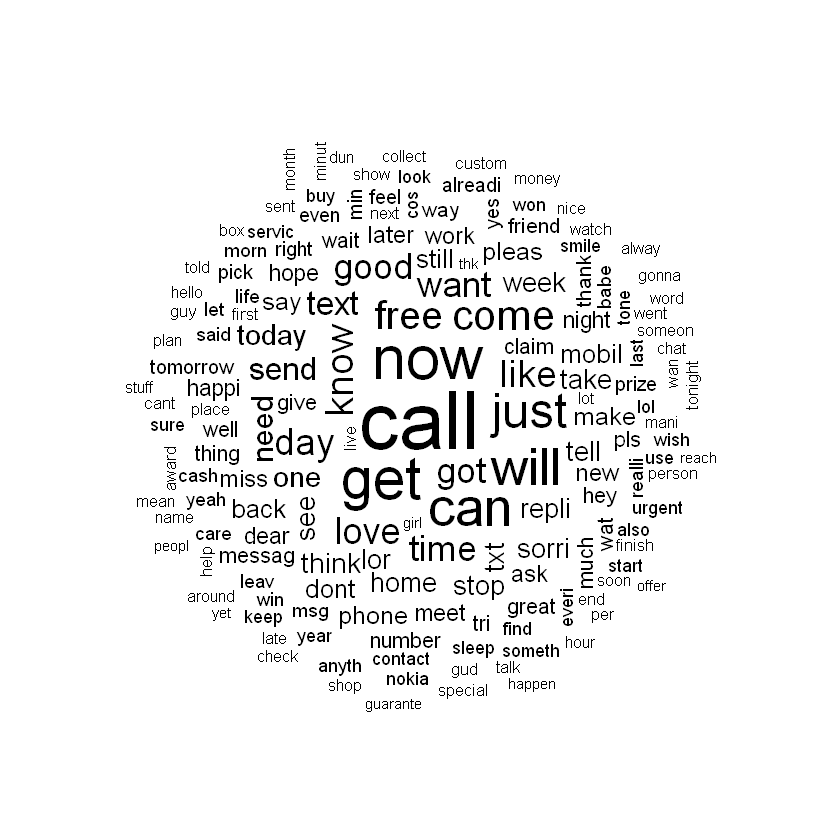

In [33]:
# Word Cloud
wordcloud(dados_corpus_clean, min.freq = 50, random.order = FALSE)

In [34]:
# Frequência dos dados
sms_dtm_freq_train <- removeSparseTerms(dados_dtm_train, 0.999)
sms_dtm_freq_train

<<DocumentTermMatrix (documents: 4169, terms: 1104)>>
Non-/sparse entries: 24827/4577749
Sparsity           : 99%
Maximal term length: 19
Weighting          : term frequency (tf)

In [35]:
# Indicador de Features para palavras frequentes
findFreqTerms(dados_dtm_train, 5)

[1] "â‚¬â\200œ"              "â£wk"                "abiola"             
   [4] "abl"                 "abt"                 "accept"             
   [7] "access"              "account"             "across"             
  [10] "act"                 "activ"               "actual"             
  [13] "add"                 "address"             "admir"              
  [16] "adult"               "advanc"              "aft"                
  [19] "afternoon"           "age"                 "ago"                
  [22] "aha"                 "ahead"               "aight"              
  [25] "aint"                "air"                 "aiyo"               
  [28] "alex"                "almost"              "alon"               
  [31] "alreadi"             "alright"             "also"               
  [34] "alway"               "angri"               "announc"            
  [37] "anoth"               "answer"              "anymor"             
  [40] "anyon"               "anyth"               "anytim"             
  [43] "anyway"              "apart"               "app"                
  [46] "appli"               "appreci"             "arcad"              
  [49] "ard"                 "area"                "argu"               
  [52] "argument"            "armand"              "around"             
  [55] "arrang"              "arriv"               "asap"               
  [58] "ask"                 "askd"                "attempt"            
  [61] "auction"             "avail"               "ave"                
  [64] "avoid"               "await"               "awak"               
  [67] "award"               "away"                "awesom"             
  [70] "babe"                "babi"                "back"               
  [73] "bad"                 "bag"                 "bank"               
  [76] "bare"                "basic"               "bath"               
  [79] "batteri"             "bcoz"                "bday"               
  [82] "beauti"              "becom"               "bed"                
  [85] "bedroom"             "beer"                "begin"              
  [88] "believ"              "best"                "better"             
  [91] "bid"                 "big"                 "bill"               
  [94] "bird"                "birthday"            "bit"                
  [97] "black"               "blank"               "bless"              
 [100] "blue"                "bluetooth"           "bold"               
 [103] "bonus"               "boo"                 "book"               
 [106] "boost"               "bore"                "boss"               
 [109] "bother"              "bout"                "box"                
 [112] "boy"                 "boytoy"              "break"              
 [115] "breath"              "bring"               "brother"            
 [118] "bslvyl"              "btnationalr"         "buck"               
 [121] "bus"                 "busi"                "buy"                
 [124] "cabin"               "call"                "caller"             
 [127] "callertun"           "camcord"             "came"               
 [130] "camera"              "campus"              "can"                
 [133] "cancel"              "cancer"              "cant"               
 [136] "car"                 "card"                "care"               
 [139] "carlo"               "case"                "cash"               
 [142] "cashbal"             "catch"               "caus"               
 [145] "celebr"              "cell"                "centr"              
 [148] "chanc"               "chang"               "charg"              
 [151] "chat"                "cheap"               "cheaper"            
 [154] "check"               "cheer"               "chennai"            
 [157] "chikku"              "childish"            "children"           
 [160] "choic"               "choos"               "christma"           
 [163] "claim"               "class"               "clean"

In [36]:
# save frequently-appearing terms to a character vector
sms_freq_words <- findFreqTerms(dados_dtm_train, 5)
str(sms_freq_words)

 chr [1:1139] "â‚¬â\200œ" "â£wk" "abiola" "abl" "abt" "accept" "access" ...


In [37]:
# Criando subsets apenas com palavras mais frequentes
sms_dtm_freq_train <- dados_dtm_train[ , sms_freq_words]
sms_dtm_freq_test <- dados_dtm_test[ , sms_freq_words]

In [38]:
# Converte para fator
convert_counts <- function(x) {
  print(x)
  x <- ifelse(x > 0, "Yes", "No")
}

In [39]:
# apply() converte counts para colunas de dados de treino e de teste
sms_train <- apply(sms_dtm_freq_train, MARGIN = 2, convert_counts)
sms_test  <- apply(sms_dtm_freq_test, MARGIN = 2, convert_counts)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [40]:
str(sms_test)

 chr [1:1390, 1:1139] "No" "No" "No" "No" "No" "No" "No" "No" "No" "No" ...
 - attr(*, "dimnames")=List of 2
  ..$ Docs : chr [1:1390] "4170" "4171" "4172" "4173" ...
  ..$ Terms: chr [1:1139] "â‚¬â\200œ" "â£wk" "abiola" "abl" ...


In [41]:
# Treinando o modelo
?naiveBayes
nb_classifier <- naiveBayes(sms_train, dados_train_labels)

In [42]:
# Avaliando o modelo
sms_test_pred <- predict(nb_classifier, sms_test)

In [43]:
# Confusion Matrix
CrossTable(sms_test_pred, 
           dados_test_labels,
           prop.chisq = FALSE, 
           prop.t = FALSE, 
           prop.r = FALSE,
           dnn = c('Previsto', 'Observado'))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1390 

 
             | Observado 
    Previsto |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1201 |        30 |      1231 | 
             |     0.995 |     0.164 |           | 
-------------|-----------|-----------|-----------|
        spam |         6 |       153 |       159 | 
             |     0.005 |     0.836 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1207 |       183 |      1390 | 
             |     0.868 |     0.132 |           | 
-------------|-----------|-----------|-----------|

 


In [44]:
# Melhorando a performance do modelo aplicando suavização laplace
nb_classifier_v2 <- naiveBayes(sms_train, dados_train_labels, laplace = 1)

In [45]:
# Avaliando o modelo
sms_test_pred2 <- predict(nb_classifier_v2, sms_test)

In [46]:
# Confusion Matrix
CrossTable(sms_test_pred2, 
           dados_test_labels,
           prop.chisq = FALSE, 
           prop.t = FALSE, 
           prop.r = FALSE,
           dnn = c('Previsto', 'Observado'))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1390 

 
             | Observado 
    Previsto |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1202 |        28 |      1230 | 
             |     0.996 |     0.153 |           | 
-------------|-----------|-----------|-----------|
        spam |         5 |       155 |       160 | 
             |     0.004 |     0.847 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1207 |       183 |      1390 | 
             |     0.868 |     0.132 |           | 
-------------|-----------|-----------|-----------|

 


In [47]:
# Nota: Para fazer novas previsões com o modelo treinado, gere uma nova massa de dados
# e use a função predict().